In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import log_loss
import matplotlib.pyplot as  plt
from sklearn import tree                                                        

MENS = 'mens'
WOMENS = 'womens'
TEST = 'test'
TRAIN = 'train'

# Columns in Data With Categorical Values- Must LabelEncode them
categorical_cols = ['hitpoint', 'outside.sideline', 'outside.baseline', 'same.side', 
                    'previous.hitpoint', 'server.is.impact.player', 'outcome']

# Columns in the Data That Should Be Scaled
scaled_data = ['serve', 'rally', 'speed', 'net.clearance', 'distance.from.sideline', 'depth', 'player.distance.travelled', 
               'player.impact.depth', 'player.impact.distance.from.center', 'player.depth', 
               'player.distance.from.center', 'previous.speed', 'previous.net.clearance', 
               'previous.distance.from.sideline', 'previous.depth', 'opponent.depth', 
               'opponent.distance.from.center', 'previous.time.to.net']

In [2]:
from sklearn.preprocessing import OneHotEncoder
from copy import deepcopy

# Load Data
mens_train = pd.read_csv('tennis_data/mens_train_file.csv')
mens_test = pd.read_csv("tennis_data/mens_test_file.csv")
# print((mens_test.head()))
# Encode Categorical Data
def encode(train, test):
    # Retain All LabelEncoder as a dictionary
    d = defaultdict(LabelEncoder)

    # Encode all the columns
    train[categorical_cols] = train[categorical_cols].apply(lambda x: d[x.name].fit_transform(x))
#     test[categorical_cols] = train[categorical_cols].apply(lambda x: d[x.name].fit_transform(x))
    test_ids = test['id']
    # Inverse the encoding
    # data.apply(lambda x: d[x.name].inverse_transform(x))
    
    # Using dictionary d to label future data
    temp = deepcopy(categorical_cols)
    temp.remove('outcome')
    e = deepcopy(d)
    del e['outcome']
#     for key in e.keys():
#         print(key)
#         print(e[key].classes_)
#     print(temp)
    
    test[temp] = test[temp].apply(lambda x: e[x.name].transform(x))
# #     print(d['hitpoint'].classes_)
    train = train.drop(['gender', 'id', 'train'], axis=1)
    test = test.drop(['gender', 'id', 'outcome', 'train'], axis=1)
    
    return train, test, test_ids, d

# print(train['serve'])
mens_train, mens_test, test_ids , d = encode(mens_train, mens_test)
# print(mens_test_X.head())


In [3]:
from sklearn.model_selection import train_test_split

mens_train_X, val_mens_X = train_test_split(mens_train, test_size=0.2, shuffle=True)
X_train = mens_train_X.loc[:, mens_train_X.columns != 'outcome']
y_train = mens_train_X['outcome']
X_val = val_mens_X.loc[:, val_mens_X.columns != 'outcome']
y_val = val_mens_X['outcome']

In [9]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_val)
    acc = accuracy_score(y_val, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_val)
    ll = log_loss(y_val, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 65.7000%
Log Loss: 5.10092734555799
SVC
****Results****
Accuracy: 43.0000%
Log Loss: 0.805641193559193
NuSVC
****Results****
Accuracy: 73.1000%
Log Loss: 0.6417882588237309
DecisionTreeClassifier
****Results****
Accuracy: 78.5000%
Log Loss: 7.425836924905798
RandomForestClassifier
****Results****
Accuracy: 82.9000%
Log Loss: 0.9394753550088816
AdaBoostClassifier
****Results****
Accuracy: 82.1000%
Log Loss: 1.04105029607881
GradientBoostingClassifier
****Results****
Accuracy: 85.4000%
Log Loss: 0.3596552731497756
GaussianNB
****Results****
Accuracy: 71.3000%
Log Loss: 1.2871046324813302
LinearDiscriminantAnalysis
****Results****
Accuracy: 78.6000%
Log Loss: 0.5499096026961973
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 75.2000%
Log Loss: 1.1134469014074622


In [26]:
def gb_grid_search():
    gb_model_m = GradientBoostingClassifier(random_state=42)

    gb_grid_params = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
                  'max_depth': [4, 6, 8],
                  'min_samples_leaf': [20, 50,100, 150],
                  'n_estimators': [75, 100, 125, 150, 200] 
                  }

    CV_gb = GridSearchCV(estimator=gb_model_m, param_grid=gb_grid_params, cv= 10, 
                          verbose=3, scoring='neg_log_loss', n_jobs=4)
    CV_gb.fit(X_train, y_train.ravel())
    best_param = CV_gb.best_params_
    return best_param
best_param = gb_grid_search()

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75 
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75 
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75 
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75, score=-0.40409114866068485, total=   3.7s
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to

[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75, score=-0.3200136562027467, total=   3.9s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75 
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75, score=-0.3519062035141428, total=   3.9s
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75, score=-0.3196615124430968, total=   4.0s
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75 
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75, score=-0.3015310524052533, total=   4.1s
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75, score=-0.31871937903734426, total=   4.6s
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75, score=-0.3266834324760151, total=   4.4s
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=100 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75, score=-0.3369942185148115, total=   4.5s
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=100 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75, score=-0.3398468030431559, total=   4.4s
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=100 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=75, score=-0.33855411326718615, total=   4.4s
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=100 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=100, score=-0.311908025419255, total=   5.8s
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=20, n_estimators=100 


KeyboardInterrupt: 

In [8]:
from sklearn.metrics import accuracy_score, log_loss

# {'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 50}
# print(best_param)
gb_model_m = GradientBoostingClassifier(n_estimators=150)
gb_model_m.fit(X_train, y_train.ravel())
val_prob_prediction = gb_model_m.predict_proba(X_val)
val_prediction = gb_model_m.predict(X_val)
acc = accuracy_score(y_val, val_prediction)
print("Accuracy: {:.4%}".format(acc))
ll = log_loss(y_val, val_prob_prediction)
print("Log Loss: {}".format(ll))

Accuracy: 85.7000%
Log Loss: 0.35761977744669377


In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss
model = XGBClassifier()
model.fit(X_train, y_train)
y_prob_pred = model.predict_proba(X_val)
y_pred = model.predict(X_val)
loss = log_loss(y_val, y_prob_pred)
acc = accuracy_score(y_val, y_pred)
print("Accuracy: {:.4%}".format(acc))
print("Log Loss: {}".format(loss))

[[ 0.08511436  0.90074933  0.01413629]
 [ 0.05240989  0.94188082  0.00570926]
 [ 0.08560685  0.15023826  0.76415485]
 ..., 
 [ 0.0069499   0.04322696  0.94982314]
 [ 0.09414429  0.90097499  0.00488072]
 [ 0.00115571  0.04422784  0.95461643]]
Accuracy: 86.2000%
Log Loss: 0.35989869678718966


In [12]:
# Test Submission
test_pred_m = model.predict_proba(mens_test)

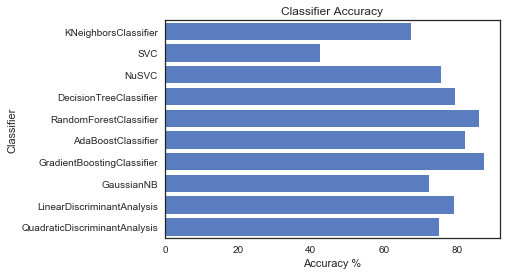

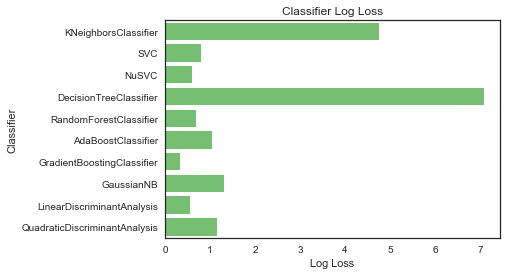

In [135]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Scale Data
def scale_data(data):
    temp = data
    scaler = MinMaxScaler()
    temp[scaled_data] = scaler.fit_transform(temp[scaled_data])
    return temp

scaled = scale_data(train)
print(scaled.head())

      rally  serve  hitpoint     speed  net.clearance  distance.from.sideline  \
0  0.028571      0         0  0.547891       0.070686                0.212587   
1  0.028571      1         0  0.509172       0.152916                0.155441   
2  0.571429      0         0  0.308242       0.053868                0.216160   
3  0.171429      0         1  0.571900       0.127759                0.035887   
4  0.028571      0         0  0.548420       0.080667                0.056191   

      depth  outside.sideline  outside.baseline  player.distance.travelled  \
0  0.571902                 0                 0                   0.101348   
1  0.219463                 0                 1                   0.159658   
2  0.793864                 0                 0                   0.269584   
3  0.281175                 1                 0                   0.040312   
4  0.462651                 0                 0                   0.161144   

    ...    opponent.depth  opponent.distance

Index(['rally', 'serve', 'hitpoint', 'speed', 'net.clearance',
       'distance.from.sideline', 'depth', 'outside.sideline',
       'outside.baseline', 'player.distance.travelled', 'player.impact.depth',
       'player.impact.distance.from.center', 'player.depth',
       'player.distance.from.center', 'previous.speed',
       'previous.net.clearance', 'previous.distance.from.sideline',
       'previous.depth', 'opponent.depth', 'opponent.distance.from.center',
       'same.side', 'previous.hitpoint', 'previous.time.to.net',
       'server.is.impact.player', 'id', 'train', 'outcome', 'gender'],
      dtype='object')


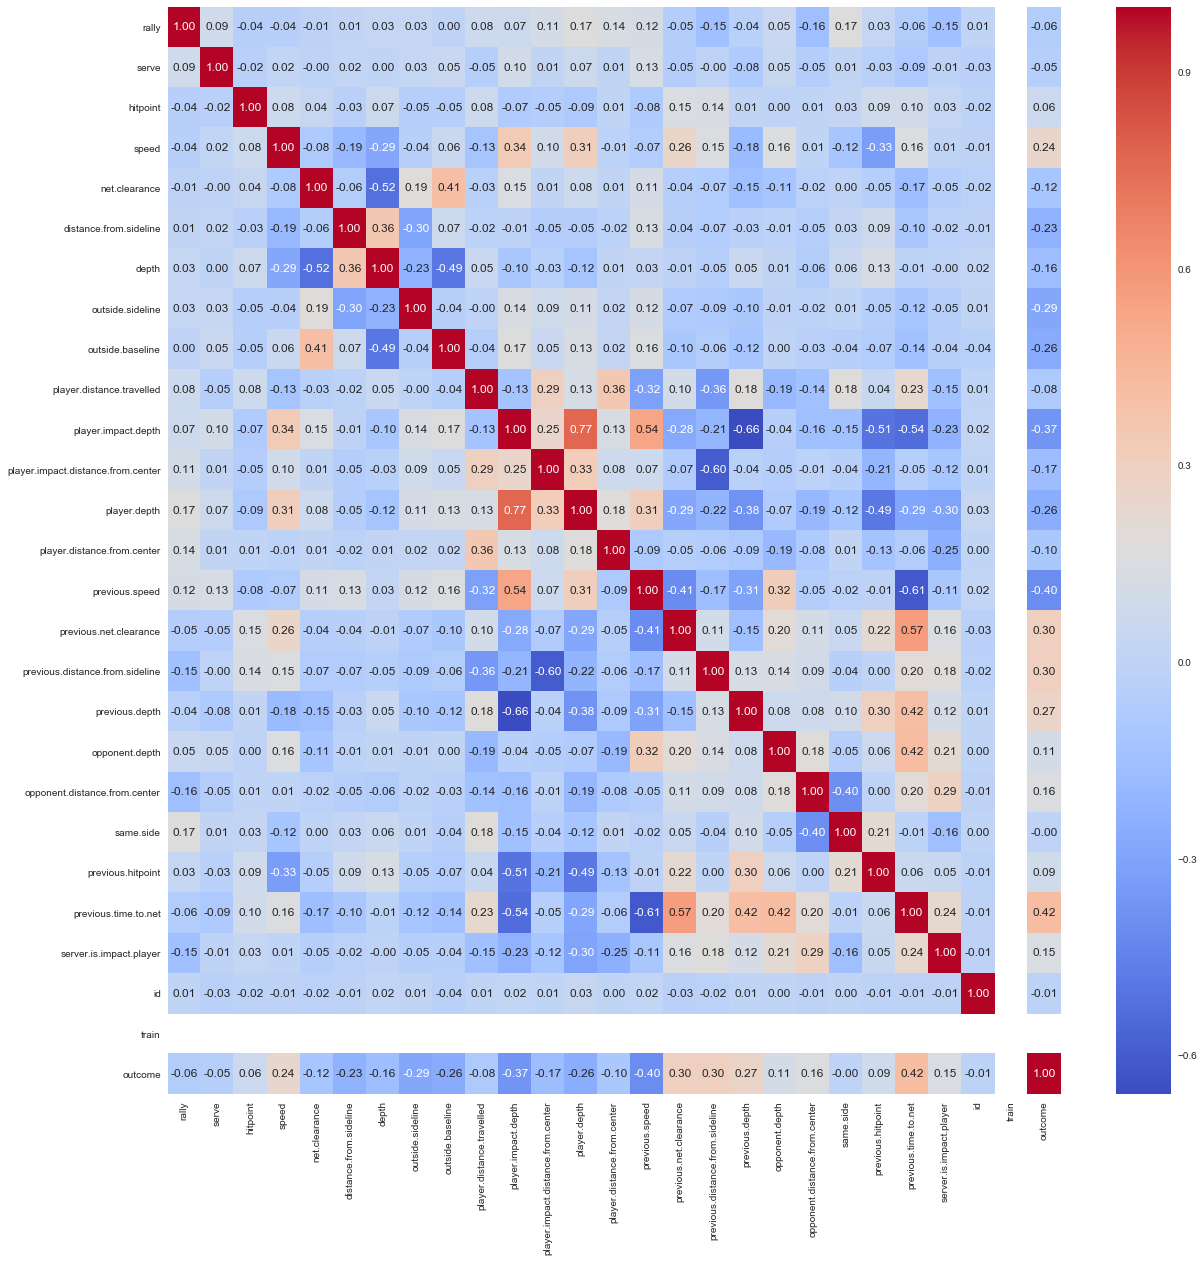

In [12]:
cols = train.columns
print(cols)
fig, ax = plt.subplots(figsize=(20,20))   
g = sns.heatmap(train[['rally', 'serve', 'hitpoint', 'speed', 'net.clearance',
       'distance.from.sideline', 'depth', 'outside.sideline',
       'outside.baseline', 'player.distance.travelled', 'player.impact.depth',
       'player.impact.distance.from.center', 'player.depth',
       'player.distance.from.center', 'previous.speed',
       'previous.net.clearance', 'previous.distance.from.sideline',
       'previous.depth', 'opponent.depth', 'opponent.distance.from.center',
       'same.side', 'previous.hitpoint', 'previous.time.to.net',
       'server.is.impact.player', 'id', 'train', 'outcome', 'gender']].corr(), 
                      annot =True, fmt = ".2f", cmap = "coolwarm")

#  'hitpoint''outside.sideline','outside.baseline', 'same.side','previous.hitpoint', 'server.is.impact.player', 'outcome', 'gender']

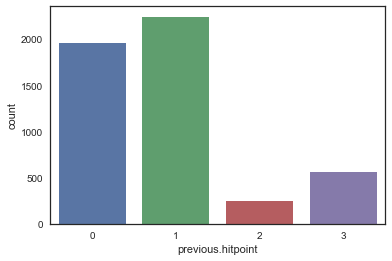

In [45]:
categorical_cols = ['hitpoint', 'outside.sideline', 'outside.baseline', 'same.side', 
                    'previous.hitpoint', 'server.is.impact.player', 'outcome']
# for x in categorical_cols:
sns.countplot(x='previous.hitpoint', data=train)

In [33]:
train.describe()

,rally,serve,hitpoint,speed,net.clearance,distance.from.sideline,depth,outside.sideline,outside.baseline,player.distance.travelled,...,previous.depth,opponent.depth,opponent.distance.from.center,same.side,previous.hitpoint,previous.time.to.net,server.is.impact.player,id,train,outcome
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.0,5000.000000
mean,6.073800,1.419200,0.746000,31.161443,0.630771,1.446501,4.582527,0.193200,0.193800,2.940785,...,4.318172,12.606633,2.466160,0.265600,0.881800,0.543950,0.575000,4767.63540,1.0,1.097200
std,3.729388,0.493478,0.668411,8.160724,1.032237,1.107850,3.194891,0.394848,0.395314,1.821582,...,2.125320,2.356896,1.346193,0.441696,0.934025,0.190789,0.494392,2755.95677,0.0,0.753038
min,3.000000,1.000000,0.000000,5.340688,-0.998184,0.000378,0.000282,0.000000,0.000000,0.000000,...,0.010852,2.161200,0.001000,0.000000,0.000000,0.079005,0.000000,1.00000,1.0,0.000000
25%,3.000000,1.000000,0.000000,25.902134,-0.033606,0.535640,1.738331,0.000000,0.000000,1.632093,...,2.754327,11.978550,1.437350,0.000000,0.000000,0.418597,0.000000,2377.75000,1.0,1.000000
50%,5.000000,1.000000,1.000000,32.913270,0.428872,1.194245,4.086093,0.000000,0.000000,2.590722,...,4.153317,12.978000,2.429400,0.000000,1.000000,0.503636,1.000000,4742.50000,1.0,1.000000
75%,7.000000,2.000000,1.000000,37.050218,0.957190,2.150703,7.251723,0.000000,0.000000,3.906332,...,5.756835,13.900700,3.372600,1.000000,1.000000,0.627682,1.000000,7183.25000,1.0,2.000000
max,38.000000,2.000000,3.000000,60.414369,12.815893,16.343755,11.885770,1.000000,1.000000,14.480546,...,9.996154,20.211000,12.995000,1.000000,3.000000,1.651724,1.000000,9531.00000,1.0,2.000000
